In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
image_size = [224, 224]

In [4]:
train_path = 'dataset/train/'
valid_path = 'dataset/valid/'
test_path = 'dataset/test/'

In [5]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import img_to_array
from keras.utils.vis_utils import plot_model
from glob import glob

In [6]:
vgg = VGG16(input_shape=image_size + [3], weights='imagenet', include_top=False)
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [7]:
for layer in vgg.layers:
    layer.trainable = False

In [8]:
test_folders = glob('dataset/train/*')
print(len(test_folders))

10


In [9]:
x = Flatten()(vgg.output)
prediction = Dense(len(test_folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Total params: 14,965,578
Trainable params: 250,890
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
adam = Adam()
model.compile(loss='categorical_crossentropy'
              ,optimizer=adam,
              metrics=['accuracy'])

batch_size = 32

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode=min
)

model_checkpoint = ModelCheckpoint(
    'vgg_best.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size= (224, 224),
                                              batch_size =batch_size,
                                              class_mode = 'categorical')

Found 15381 images belonging to 10 classes.


In [14]:
valid_test = test_datagen.flow_from_directory(valid_path,
                                              target_size= (224, 224),
                                              batch_size =batch_size,
                                              class_mode = 'categorical')

Found 3302 images belonging to 10 classes.


In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from datetime import datetime

callbacks = [model_checkpoint]

start = datetime.now()

model_history = model.fit_generator(
    train_set,
    validation_data=valid_test,
    epochs=40,
    steps_per_epoch=30,
    validation_steps=32,
    callbacks=[early_stop, callbacks],
    verbose=2
)
# steps_per_epoch=5,

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.62305, saving model to vgg_best.h5
15/15 - 157s - loss: 11.1329 - accuracy: 0.4646 - val_loss: 9.1918 - val_accuracy: 0.6230 - 157s/epoch - 10s/step
Epoch 2/40

Epoch 2: val_accuracy improved from 0.62305 to 0.70020, saving model to vgg_best.h5
15/15 - 163s - loss: 7.7038 - accuracy: 0.6271 - val_loss: 7.8022 - val_accuracy: 0.7002 - 163s/epoch - 11s/step
Epoch 3/40

Epoch 3: val_accuracy improved from 0.70020 to 0.75000, saving model to vgg_best.h5
15/15 - 155s - loss: 6.3052 - accuracy: 0.7312 - val_loss: 5.7620 - val_accuracy: 0.7500 - 155s/epoch - 10s/step
Epoch 4/40

Epoch 4: val_accuracy improved from 0.75000 to 0.77441, saving model to vgg_best.h5
15/15 - 158s - loss: 6.4277 - accuracy: 0.7354 - val_loss: 5.7670 - val_accuracy: 0.7744 - 158s/epoch - 11s/step
Epoch 5/40

Epoch 5: val_accuracy improved from 0.77441 to 0.78027, saving model to vgg_best.h5
15/15 - 158s - loss: 5.4517 - accuracy: 0.8000 - val_loss: 7.0057 - va

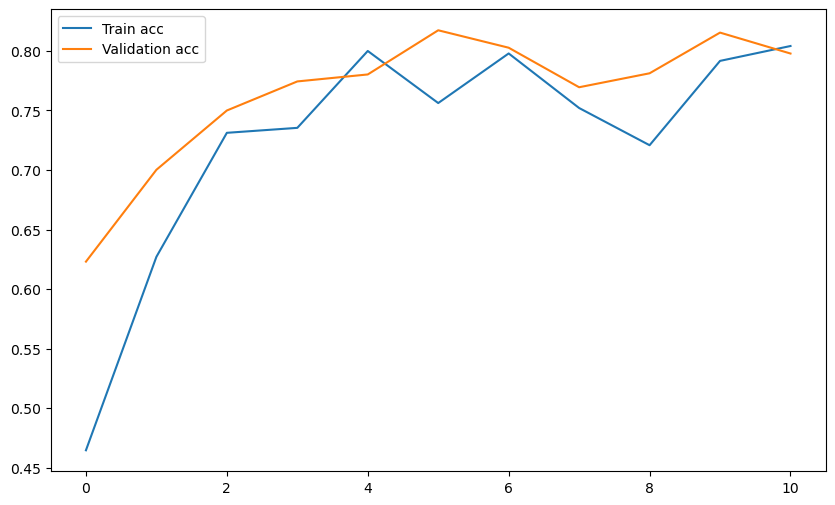

In [16]:
plt.figure(figsize=[10,6])
plt.plot(model_history.history["accuracy"], label = "Train acc")
plt.plot(model_history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

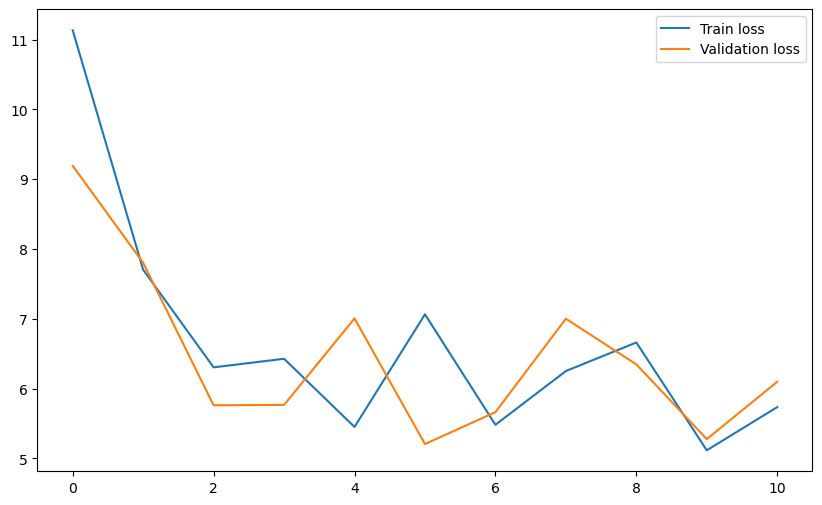

In [17]:
plt.figure(figsize=(10,6))
plt.plot(model_history.history['loss'], label = "Train loss")
plt.plot(model_history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [18]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Battery"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Biological"+"\033[0m")
    elif result ==2: print("\033[94m"+"This image -> Cardboard"+"\033[0m")
    elif result ==3: print("\033[94m"+"This image -> Clothes"+"\033[0m")
    elif result ==4: print("\033[94m"+"This image -> Glass"+"\033[0m")
    elif result ==5: print("\033[94m"+"This image -> Metal"+"\033[0m")
    elif result ==6: print("\033[94m"+"This image -> Paper"+"\033[0m")
    elif result ==7: print("\033[94m"+"This image -> Plastic"+"\033[0m")
    elif result ==8: print("\033[94m"+"This image -> Shoes"+"\033[0m")
    elif result ==9: print("\033[94m"+"This image -> Trash"+"\033[0m")

1/1 [==============================] - 0s 365ms/step
This image -> Paper


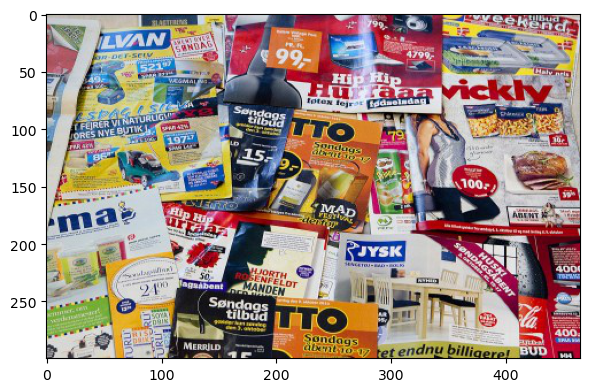

In [19]:
test_img = cv2.imread("dataset/test/paper/paper_001.jpeg")
predict_func(test_img)